# MAT dSTRF Rothman fit

In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
from models import cosstrf, mat, dstrf_mat

from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Setting paramters and loading data

In [2]:
# assimilation parameters
nwalkers = 1000
burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# dstrf model settings
free_ts = False
scale = 10
channels = 1
ncos = 10
coslin = 10
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# load data
model = "tonic-off/"

%time stims,durations,spikes_data,spiky_data = utils.load_rothman(model,nspec,t_dsample,compress)
psth_data = [utils.psth(spk,dur,t_dsample,dsample=t_dsample) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

CPU times: user 14.9 s, sys: 84 ms, total: 14.9 s
Wall time: 15.7 s
EO: 0.66


## Getting initial guess for STRF

In [3]:
# estimate STRF using elastic net regression
fit_psth = [p*1000 for p in assim_psth]
#fit_psth = [normalize(p,False) for p in assim_psth]

%time STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=False)

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


CPU times: user 48.7 s, sys: 1min 8s, total: 1min 57s
Wall time: 32.3 s


../utils.py:316: RuntimeWarning: invalid value encountered in true_divide
  if norm: basis /= np.linalg.norm(basis,axis=0)


0.617482332561


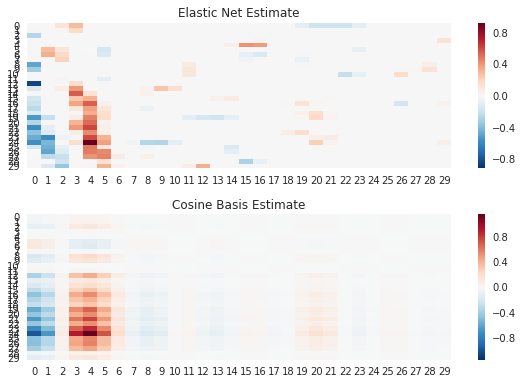

In [4]:
hyper = utils.hyper_opt(assim_stims,assim_psth,STRF_GUESS,nspec,tlen)
channels, ncos, coslin = hyper.search()

# factorize STRF using SVD
SPEC,TIM = utils.factorize(STRF_GUESS,channels)

# setup cosine basis
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True,norm=True)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC.flatten(),tot(TIM).flatten()))

# plot elastic net and cosine estimate
subplot(211)
title("Elastic Net Estimate")
sns.heatmap(STRF_GUESS)

subplot(212)
title("Cosine Basis Estimate")
strf_model = cosstrf(channels,nspec,tlen,ncos,coslin,normalize=norm,center=center)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

tight_layout()
print(utils.evaluate(strf_model.filt,test_stims,test_psth))

## Define loss and prior functions

In [5]:
from neurofit import priors
from neurofit import costs

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    dist = 1000*np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    return dist

mat_prior = priors.joint_independent(
                [ nf.priors.uniform(-1000,  1000),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -1000,  1000)])

cost = spike_distance
unbounded = priors.unbounded()

def dstrf_shrink_prior(theta):
    return np.sum(np.abs(start[:-4])) + mat_prior(start[-4:])

## Run initial MAT parameter fit

In [6]:
from neurofit import startpos

# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the mat model
mat_model = mat(free_ts=free_ts)

# generate starting positions of emcee walkers
p0 = startpos.uniform_independent(nwalkers,[-100,-10,-10,-10],[100,10,10,10])
#p0 = startpos.normal_independent(nwalkers,[10,1,0.1,1],[0.1]*4)

# run emcee
mat_smplr = nf.sampler(mat_model,mat_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),8)

for pos,_,_ in tracker(mat_smplr.sample(p0,iterations=burn)): continue
mat_smplr.reset()
mat_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -2593.6     0:01:39     0:15:02
   200     -2573.6     0:03:04     0:12:20
   300     -2570.3     0:04:29     0:10:32
   400     -2568.7     0:05:55     0:08:55
   500     -2567.8     0:07:20     0:07:22
   600     -2567.2     0:08:44     0:05:51
   700     -2566.7     0:10:08     0:04:22
   800     -2566.3     0:11:33     0:02:54
   900       -2566     0:12:57     0:01:27
  1000     -2565.6     0:14:20     0:00:00
  1001     -2565.6     0:14:21     0:00:00


In [7]:
# check the performance of the fit mat model
mml = mat_smplr.flatchain[np.argmax(mat_smplr.flatlnprobability)]
mat_map = mat()
mat_map.set(mml)
mat_corr = []

param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d in zip(test_Iapp,test_psth,test_dur):
    trace,spikes = mat_map.run(i)
    mat_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    mat_corr.append(np.corrcoef(p,mat_psth)[0][1])
        
start = np.hstack((filt_start,mml))
print("Filt R: {:.3f}, MAT R: {:.3f}".format(param_corr,np.mean(mat_corr)))

Filt R: 0.617, MAT R: 0.600


## Fit dSTRF model using emcee

In [11]:
# initalize the model
model = dstrf_mat(channels,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center)

# set starting positions for walkers
p0 = startpos.normal_independent(nwalkers-1,start,[1e-4]*len(start))
p0 = np.vstack((start,p0))

# run emcee
dstrf_smplr = nf.sampler(model,dstrf_shrink_prior,spike_distance,nwalkers,zip(assim_stims,assim_spiky),threads)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -2835.8     0:06:20     0:57:43
   200     -2546.6     0:12:41     0:51:06
   300     -2466.1     0:19:04     0:44:44
   400     -2418.4     0:25:27     0:38:20
   500     -2392.3     0:31:48     0:31:55
   600     -2376.9     0:38:09     0:25:32
   700       -2367     0:44:30     0:19:10
   800     -2360.1     0:50:51     0:12:47
   900     -2354.9     0:57:11     0:06:25
  1000     -2350.9     1:03:32     0:00:03
  1001     -2350.9     1:03:36     0:00:00


## Evaluate the model fit

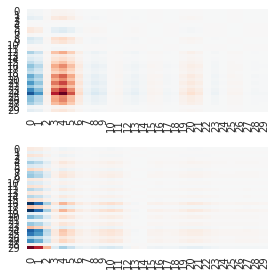

In [12]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))

# compare EN and dstrf STRFs
subplot(211)
sns.heatmap(strf_model.filt,cbar=False)

subplot(212)
sns.heatmap(model.pstrf.filt,cbar = False)
tight_layout()

In [15]:
map_corr = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,t_dsample,psth_smooth)
ppcorr = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("MAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))

MAP: 0.54, Dist: 0.61, EO: 0.65
MAP/EO: 0.84, Dist/EO: 0.94


In [ ]:
from corner import corner

matlabs = ['a','b','c','w']
corner(dstrf_smplr.flatchain[:,-4:],
       range=[[-100,100],
              [-10,10],
              [-10,10],
              [-100,100]],
       bins=50, smooth=2,mooth1d=5,
       labels=matlabs);